<a href="https://colab.research.google.com/github/ultralytics/yolov5/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://user-images.githubusercontent.com/26833433/82952157-51b7db00-9f5d-11ea-8f4b-dda1ffecf992.jpg">

This notebook was developed by Ultralytics LLC, and **is freely available for redistribution under the GPL-3.0 license**. For more information please visit https://github.com/ultralytics/yolov5 and https://www.ultralytics.com.

#Initial Setup

Clone repo, install dependencies, `%cd` into `./yolov5` folder and check GPU.

# Load model

#1. Inference

Run inference with a pretrained checkpoint on contents of `/inference/images` folder. Models are downloaded automatically from our Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J) if available.

In [1]:
import torch
torch.cuda.empty_cache()
print(torch.cuda.get_device_name(),torch.cuda.get_device_properties(0), torch.__version__)

Quadro P2000 _CudaDeviceProperties(name='Quadro P2000', major=6, minor=1, total_memory=4096MB, multi_processor_count=6) 1.6.0


In [2]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import re
import csv
from shapely.geometry import Point as P
from shapely.geometry.polygon import LinearRing, Polygon
from collections import deque
from utils.datasets import *
from utils.utils import *
%matplotlib inline 
from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from tools import generate_detections as gdet
from intersection import *
import utm
from  Mapping import Mapping

C:\Users\piyalong\AppData\Local\Continuum\anaconda3\envs\tensor1.4\lib\site-packages\sklearn\utils\linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [3]:
real_reference = [[4378, 758], [1577,3531], [9716, 12871], [11612, 6791]]
pixel_reference = [[1725,965], [34,643], [1048,34], [1737,108]]
pixelzones={
"zone1" : [(1734,970),(1738,1080),(875,1080),(1116,678),(1318,872)],
"zone2" : [(1019,848),(882,800),(1346, 134),(1400, 139)],
"zone3" : [(882,800),(733,775),(1294, 129),(1346, 134)],
"zone4" : [(733,775),(612,747),(1245, 125),(1294, 130)],
"zone19" : [(791,570),(914,367),[1201, 121] ,[1245, 125]],
"zone5" : [(453,725),(355,689),[1102, 112], [1151, 116]],
"zone6" : [(355,689),(273,659),[1057, 108], [1102, 112]],
"zone7" : [(273,659),(193,628),[1019, 104] ,[1057, 108]],
"zone8" : [(204,619),(226,529),(3,504),(1,394),(411,419),(596,375)],
"zone9" : [(895,95),(647,94),(668,71),(945,72)],
"zone10" : [(1413,141),(1017,104),(975,92),(1018,75),(1075,69),(1442,89)],
"zone11" : [[1116, 71] ,[1071, 69],(1196,0),(1222,0)],
"zone12" : [[1154, 73], [1115, 71],(1222,0),(1251,0)],
"zone13" : [[1190, 75], [1154, 73],(1251,0),(1279,0)],
"zone14" : [[1228, 77] ,[1190, 75],(1279,0),(1307,0)],
"zone15" : [[1270, 80] ,[1228, 77],(1307,0),(1340,0)],
"zone16" : [[1337, 83], [1292, 81],(1369,0),(1401,0)],
"zone17" : [[1379, 86], [1337, 83],(1401,0),(1434,0)],
"zone18" : [[1433, 89], [1379, 86],(1434,0),(1468,0)],
}

Using CUDA device0 _CudaDeviceProperties(name='Quadro P2000', total_memory=4096MB)

mapping running!


C:\Users\piyalong\yolov5-master\yolov5-master\utils\utils.py:570: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  i, j = (x[:, 5:] > conf_thres).nonzero().t()
C:\Users\piyalong\AppData\Local\Continuum\anaconda3\envs\tensor1.4\lib\site-packages\ipykernel_launcher.py:184: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\piyalong\AppData\Local\Continuum\anaconda3\envs\tensor1.4\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


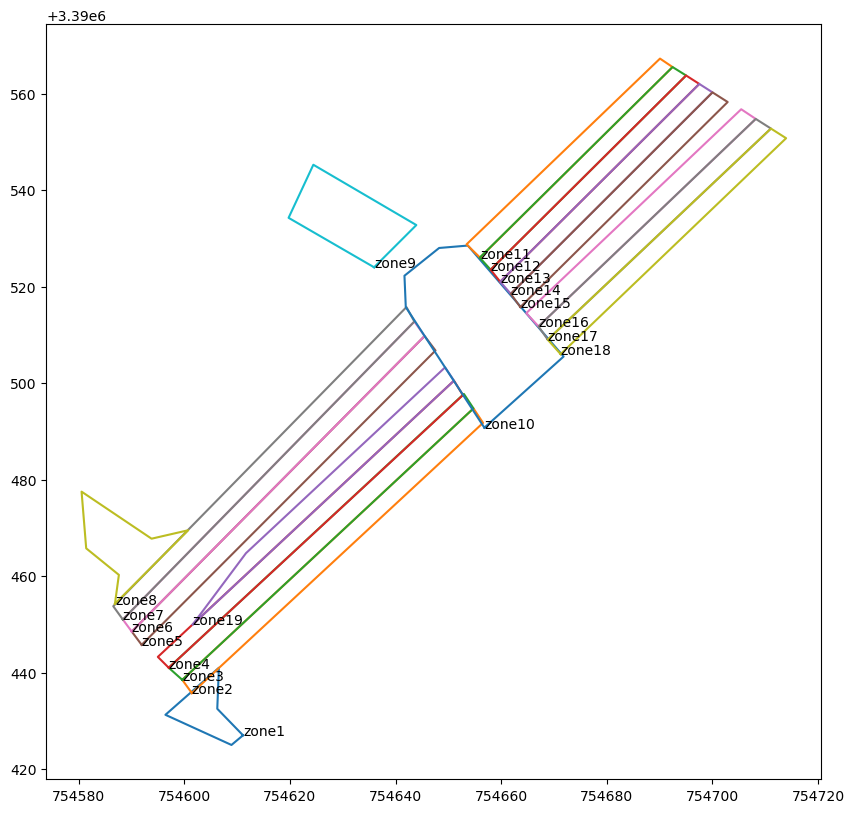

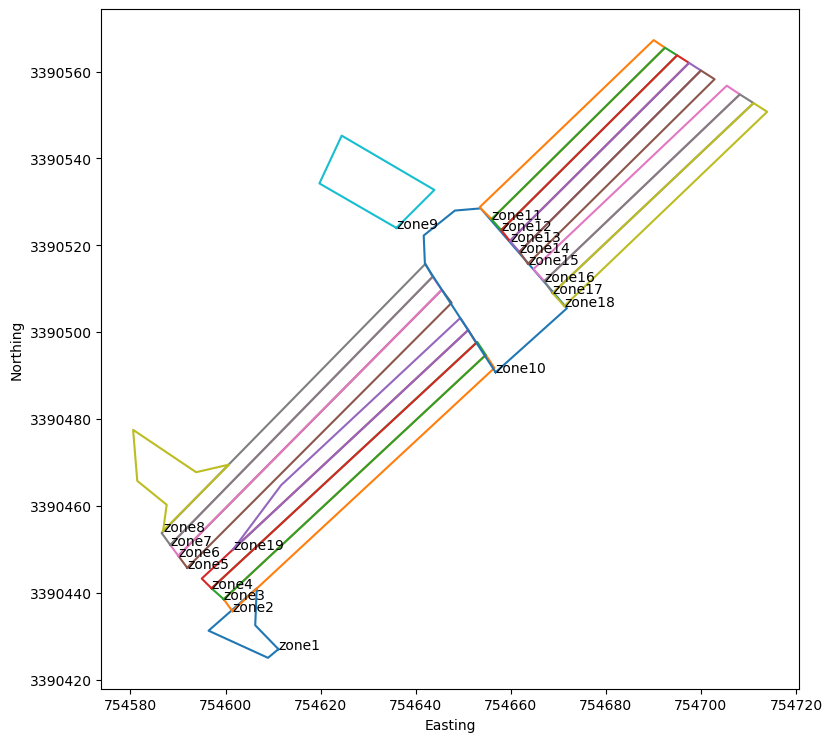

In [5]:
# Deep SORT parameters
max_cosine_distance = 0.3
nn_budget = None
nms_max_overlap = 1.0
model_filename = 'model_data/mars-small128.pb'
# YOLO v5 parameters
device_id='cuda:0'
weights = "weights/yolov5x.pt"
img_size=imgsz=1024
writeVideo_flag = True
conf_thres=0.27
iou_thres =0
classes=None
agnostic_nms=False
#mapping parameters
classes_interested = {0:"Pedestrain",2:"Car",5:"Bus", 7:"Truck"}
buffer = 15
lat_long_reference = [[30.619373, -96.343922], [30.619625, -96.344209], [30.620465, -96.343356], [30.619915, -96.343156]]
real_reference = [utm.from_latlon(i,j)[:2] for i,j in lat_long_reference]
pixel_reference = [[1725,965], [34,643], [1048,34], [1737,108]]

colors = [ 
(0,0,255),
(102,204,0), 
(255,0,255),
(0,128,255),
(255,128,0),
(255,192,203),
(128,128,128),
(0,204,204),
(0,0,128)
]

trajectory={i:{} for i in classes_interested.values()}
trajectory_wait={i:{} for i in classes_interested.values()}

encoder = gdet.create_box_encoder(model_filename,batch_size=1)
# metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
tracker = {class_name:Tracker(nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)) for class_name in classes_interested.values()}
# tracker2 = Tracker(metric)

file_path = 'NSG _ PTZ NW Roof-2020-05-13_08h01min00s000ms.mp4_63_min.mp4'
video_capture = cv2.VideoCapture(file_path)
device = torch_utils.select_device(device_id)
half = device.type != 'cpu'  # half precision only supported on CUDA
model = torch.load(weights, map_location=device_id)['model'].float()  # load to FP32
if half:
    model.half()  # to FP16
model.to(device).eval()
img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
names = model.names if hasattr(model, 'names') else model.modules.names
maps = Mapping(real_reference,pixel_reference, pixelzones)
maps.show_study_zones()

if writeVideo_flag:
    fig_size = 1000
    w = int(video_capture.get(3))
    h = int(video_capture.get(4))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(file_path[:-4]+'test_detection.avi', fourcc, 15, (w, h))
    mapout = cv2.VideoWriter(file_path[:-4]+'test_mapping.avi', fourcc, 15,(fig_size,fig_size))
with open(file_path[:-4]+"_raw_points.csv", "w",newline='') as a_file,open(file_path[:-4]+"_pathway.csv", "w",newline='') as b_file:
    writera = csv.writer(a_file)
    writerb = csv.writer(b_file)
    frame_index = -1
    while True:
        fig, ax = plt.subplots(1,1,figsize = (9,9),dpi=100)
        plt.xlabel('Easting', fontsize=10,)
        plt.ylabel('Northing', fontsize=10)
        plt.ticklabel_format(useOffset=False, style='plain')
        for lane_name,checkzone in maps.checkzones.items():
            poly = Polygon(checkzone)
            x,y = poly.exterior.xy
            ring = LinearRing(checkzone)
            x, y = ring.xy
            plt.plot(x, y)    
            plt.text(checkzone[0][0],checkzone[0][1],lane_name)

        ret, frame = video_capture.read()  # frame shape 640*480*3
        if ret != True:
            break
        imgtest = letterbox(frame, new_shape=img_size)[0]
        imgtest = imgtest[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
        imgtest = np.ascontiguousarray(imgtest)
        imgtest  = torch.from_numpy(imgtest).to(device)
        imgtest = imgtest.half() if half else imgtest.float()  # uint8 to fp16/32
        if imgtest.ndimension() == 3:
            imgtest = imgtest.unsqueeze(0)
        imgtest /= 255.0  # 0 - 255 to 0.0 - 1.0
        #     imgtest.shape
        pred = model(imgtest)[0]
        pred = non_max_suppression(pred, conf_thres, iou_thres, fast=True, classes=classes, agnostic=agnostic_nms)
        object_tracked={i:{'dets':[],'conf':[]} for i in classes_interested.values()}
        
        for i, det in enumerate(pred):  # detections per image
            if det is not None:
                # Rescale boxes from img_size to frame size
                det[:, :4] = scale_coords(imgtest.shape[2:], det[:, :4], frame.shape).round()
                for *xyxy, conf, cls in det:
                    if int(cls) not in classes_interested:
                        continue
                    if int(cls) in [2,7]:
                        cls=2
                    label = '%s %.2f' % (names[int(cls)], conf)
                    plot_one_box(xyxy, frame, label=label, color=colors[int(cls)], line_thickness=3)
                    x1,y1,x2,y2 = [ i.item () for i in xyxy]
                    object_tracked[classes_interested[int(cls)]]['dets'].append([x1, y1, x2-x1, y2-y1])
#                     dets.append([x1, y1, x2-x1, y2-y1])
                    object_tracked[classes_interested[int(cls)]]['conf'].append(float(conf))
        for class_name, queue in object_tracked.items():
            dets= queue['dets']
            confidence =queue['conf']
            # Process detections


            features = encoder(frame,dets)
            detections = [Detection(bbox, confidence, feature) for bbox, confidence, feature in zip(dets, confidence, features)]
            boxes = np.array([d.tlwh for d in detections])
            scores = np.array([d.confidence for d in detections])
            indices = preprocessing.non_max_suppression(boxes, nms_max_overlap, scores)
            detections = [detections[i] for i in indices]
            # Call the tracker
            tracker[class_name].predict()
            tracker[class_name].update(detections)

            for track in tracker[class_name].tracks:
                if not track.is_confirmed() or track.time_since_update > 1:
                    continue 
                bbox = track.to_tlbr()
                x_bc,y_bc = int((bbox[0]+bbox[2])/2),int(bbox[3])
                cv2.rectangle(frame, (int(bbox[0]), int(bbox[3])), (int(bbox[2]), int(bbox[3]+20)), (255,0,0), -1)
                cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(255,0,0), 2)
                cv2.putText(frame, '#'+str(track.track_id),(int(bbox[0]), int(bbox[3]+20)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255), 2)
                obj_id=int(track.track_id)
                if obj_id not in trajectory[class_name]:
                    trajectory[class_name].update({obj_id:deque(maxlen=buffer)})
                    trajectory_wait[class_name].update({obj_id:0})
                trajectory_wait[class_name][obj_id]+=1
                trajectory[class_name][obj_id].appendleft((x_bc,y_bc))
            trajectory_wait[class_name] = {k:v-1 for k,v in trajectory_wait[class_name].items()}
            for k,v in trajectory_wait[class_name].items():
                if v<0 and k in trajectory[class_name].keys():
                    del trajectory[class_name][k]
            rawpoints = maps.project_trajectory(trajectory[class_name])
            waypoints = maps.Waypoint(trajectory[class_name])
########################################################################################################################################

            for key, pts in trajectory[class_name].items():
                line_color = (0, 0, 255)
                for i in np.arange(1, len(pts)):
                    if pts[i - 1] is None or pts[i] is None:
                        continue
                    else: 
                        thickness = int(np.sqrt(buffer / float(i + 1)) * 2.5)
                        cv2.line(frame, pts[i - 1], pts[i], line_color, thickness)
            for k,v in rawpoints.items():
                if v is not None and len(v)>1:
                    i = [float(x[0]) for x in v]
                    j = [float(x[1]) for x in v]
                    plt.plot(i, j,"r")
                    x1,y1,x2,y2 = v[0][0],v[0][1],v[-1][0],v[-1][1]
                    dist = math.hypot(x2 - x1, y2 - y1)
                    speed = (dist*(buffer/15))*2.23694
                    plt.text(v[0][0],v[0][1]+200,'#'+str(k)+":"+str(round(speed))+" MPH",fontsize=2)
                    plt.plot(v[0][0],v[0][1],'mo',markersize=10)

#                     print(k)
                    writera.writerow([round(k),class_name,frame_index,v[0][0],v[0][1]])
            for k,v in waypoints.items():
                content = [round(k),class_name,frame_index]
                if v is not None and len(v)>1:
                    content.extend(v)
                    writerb.writerow(content)

######################################################################################################################################                    
    
        if writeVideo_flag :

            cv2.putText(frame, 'Frame: '+str(frame_index), (0,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 3)

            show = cv2.resize(frame,(1280,720))
            cv2.imshow('Frame', show)
            fig.canvas.draw()
            the_map = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
            the_map  = the_map.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            the_map = cv2.cvtColor(the_map,cv2.COLOR_RGB2BGR)
            the_map = cv2.resize(the_map,(fig_size,fig_size))
            cv2.imshow("Map", the_map)
            out.write(frame)
            mapout.write(the_map)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        plt.close()
        frame_index = frame_index + 1
#         print(frame_index)
###Clean up#############################################################################################################################
    if writeVideo_flag:
        out.release()
        mapout.release()
    cv2.destroyAllWindows()

In [17]:
cv2.destroyAllWindows()

In [8]:
for k,v in waypoints.items():
    print(v)


In [ ]:
trajectory_wait

In [8]:
object_tracked

{'Pedestrain': {}, 'Car': {}, 'Bus': {}, 'Truck': {}}

In [5]:
features

array([], shape=(0, 128), dtype=float32)

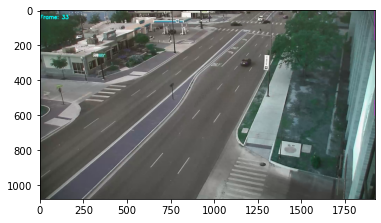

In [13]:
plt.imshow(frame)

In [16]:
detections = [Detection(bbox, confidence, feature) for bbox, confidence, feature in zip(dets, confidence, features)]


In [17]:
detections

[]

In [91]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point as P
from shapely.geometry.polygon import LinearRing, Polygon
import intersection

class Mapping():
    def __init__(self,real_reference,pixel_reference, pixelzones):
        self.real_reference =real_reference
        self.pixel_reference=pixel_reference
        self.pixelzones = pixelzones
        self.M = cv2.getPerspectiveTransform(np.float32(self.pixel_reference),np.float32(self.real_reference))
        self.checkzones = {}

        print("mapping running!")
        
    def show_study_zones(self):
        fig, ax = plt.subplots(1,1,figsize = (10,10),dpi=100)
        for lane_name, pixelzone in self.pixelzones.items():
            checkzone =[]
            for each_point in pixelzone:
                x_bc,y_bc = each_point

                point_1 = np.array([[[x_bc,y_bc]]], dtype='float32')  
                projected_position = cv2.perspectiveTransform(point_1, self.M)
                position_on_map = tuple(projected_position[0][0])
                checkzone.append(position_on_map)
            poly = Polygon(checkzone)
            x,y = poly.exterior.xy
            ring = LinearRing(checkzone)
            x, y = ring.xy
            plt.plot(x, y)    
            plt.text(checkzone[0][0],checkzone[0][1],lane_name)
            self.checkzones.update({lane_name:checkzone})
        plt.savefig("study zones.png")
                
    def project_trajectory(self,trajectories):
        projected_trajectory = {}

        for k,v in trajectories.items():
            mapped= []
            for each_point in v:
                point = np.array([[[each_point[0],each_point[1]]]], dtype='float32')  
                projected_position = cv2.perspectiveTransform(point, self.M)
                position_on_map = tuple(projected_position[0][0])
                last_point = P(position_on_map)
#                 print(last_point)

                for check_zone in self.checkzones.values():
                    polygon = Polygon(check_zone)
                    if  polygon.contains(last_point):
                        mapped.append(position_on_map)
                    else:continue
            projected_trajectory[k]=mapped
        return projected_trajectory
    def Waypoint (self,trajectories):
        results = {}
        for k,v in trajectories.items():
            mapped= []
            for each_point in v:
                point = np.array([[[each_point[0],each_point[1]]]], dtype='float32')  
                projected_position = cv2.perspectiveTransform(point, self.M)
                position_on_map = tuple(projected_position[0][0])
                last_point = P(position_on_map)
                mapped.append(position_on_map)
            if (len(mapped))<2:continue
            traj_line=[mapped[0],mapped[1]]
            last_point = P(mapped[0])

            for lane_name, check_zone in self.checkzones.items():
                zone = Polygon(check_zone)
                for i in range(1,len(check_zone)):
                    checkline = (check_zone[i],check_zone[i-1])
            #         break
                    if(check_cross(checkline,traj_line)) :
                        sense = ""
                        if  zone.contains(last_point):
                            sense="ingress "
                        else:
                            sense="egress "
                        results.update({k:[traj_line,checkline,sense]}) 
        return results

In [84]:
mapss  = Mapping(real_reference,pixel_reference, pixelzones)

mapping running!


In [85]:
mapss.Waypoint(trajectory["Car"])

{}

In [53]:
a

{}

In [ ]:
pp.contains(point)

In [ ]:
pp

In [9]:
waypoints

{}

In [ ]:
for each in maps.checkzones.values():
#     print(each)
    PP = Polygon(each)
#     print(PP)
    print(PP.contains(point))

In [5]:
trajectory

{'Pedestrain': {}, 'Car': {}, 'Bus': {}, 'Truck': {}}

In [ ]:
for lane_name,checkzone in maps.checkzones.items():
    poly = Polygon(checkzone)
    x,y = poly.exterior.xy
    ring = LinearRing(checkzone)
    x, y = ring.xy
    plt.plot(x, y)    
    plt.text(checkzone[0][0],checkzone[0][1],lane_name)

In [ ]:
conf_thres=0.2


In [ ]:
GT_list = os.listdir("C:/Users/piyalong/TAMIDS traffic management/NSG_annotation/")
txt_list=[]
video_list=[]
for filename in GT_list:
    if filename.endswith("txt"):
        txt_list.append(filename)
    if filename.endswith("m4v"):
        video_list.append(filename)